# Qredo transaction activity - Data Analysis

#### Maria Silva, June 2023

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Process data

In [2]:
file = os.path.realpath("../data/transaction_billables_2023-06-12T12_25_09.239538Z.csv")
raw_vol_df = pd.read_csv(file)

raw_vol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68394 entries, 0 to 68393
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Billable ID           68394 non-null  object 
 1   Billable Type         68394 non-null  int64  
 2   Billable Status       68394 non-null  int64  
 3   Billable Type S       68394 non-null  object 
 4   Billable Status S     68394 non-null  object 
 5   Status Error          1751 non-null   object 
 6   Entity ID             68394 non-null  object 
 7   Source Tx             68394 non-null  object 
 8   From Addr             41300 non-null  object 
 9   To Addr               46214 non-null  object 
 10  Smart Contract        32398 non-null  object 
 11  Smart Contract Index  68394 non-null  int64  
 12  Symbol                46214 non-null  object 
 13  Amount                68394 non-null  float64
 14  Fiat Symbol           46214 non-null  object 
 15  Fiat Amount        

**There is a weird transaction we are excluding:**

In [3]:
raw_vol_df[(raw_vol_df["Billable Status S"]=="NotBillable") & (raw_vol_df["Fee Amount"]>0)]

,Billable ID,Billable Type,Billable Status,Billable Type S,Billable Status S,Status Error,Entity ID,Source Tx,From Addr,To Addr,...,Fiat Symbol,Fiat Amount,Fee Amount,Fee Symbol,Rate,Rate Provider,Rate Time,Created At,Fee Tx,Fee Percent
65668,2OyA20jX1fxKSkVAG9jRX7dTpAS,1,3,ExternalTransfer,NotBillable,NaN,28I6QQ3ZK9RBLXrLvBQP02IqXpL,2Oy8rl9G469yTMNxigVG2T04QJZ,0x9Ed2078F053D377201FdF63f4b0905E3bBF3F79e,0xfd225c9e6601c9d38d8f98d8731bf59efcf8c0e3,...,USD,1.043250e+09,52162.5,NaN,1.04325,Coinbase,2023-04-26T15:17:16Z,2023-04-26T15:17:16Z,NaN,0.005


In [4]:
cols = ['Billable Type S', 'Billable Status S', 'Amount', 'Symbol', 'Fiat Amount','Fee Amount','Fee Tx']
vol_df = raw_vol_df[raw_vol_df["Billable ID"]!="2OyA20jX1fxKSkVAG9jRX7dTpAS"][cols].copy()
vol_df.columns = [c.lower().replace(" ", "_") for c in cols]

vol_df["billable"] = np.where(vol_df["billable_status_s"]=="NotBillable", False, True)
vol_df["billable_type_s"] =  np.where(vol_df["billable_type_s"]=="L2Settle", "QL2", "MMI")
vol_df["created_at"] = pd.to_datetime(raw_vol_df["Created At"])
vol_df["day"] = pd.to_datetime(vol_df["created_at"].dt.date)
vol_df["year_month"] = vol_df["day"].dt.year.astype("str") + "-" + vol_df["day"].dt.month.astype("str")

vol_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68393 entries, 0 to 68393
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   billable_type_s    68393 non-null  object             
 1   billable_status_s  68393 non-null  object             
 2   amount             68393 non-null  float64            
 3   symbol             46213 non-null  object             
 4   fiat_amount        68393 non-null  float64            
 5   fee_amount         68393 non-null  float64            
 6   fee_tx             5499 non-null   object             
 7   billable           68393 non-null  bool               
 8   created_at         68393 non-null  datetime64[ns, UTC]
 9   day                68393 non-null  datetime64[ns]     
 10  year_month         68393 non-null  object             
dtypes: bool(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(3), object(5)
memory usage: 5.8+ MB


In [5]:
vol_df.head(2).T

,0,1
billable_type_s,QL2,MMI
billable_status_s,NotChargeable,NotChargeable
amount,82.290085,7.0
symbol,QRDO,ETH
fiat_amount,18.745101,9344.545
fee_amount,1.0,38.282958
fee_tx,NaN,NaN
billable,True,True
created_at,2022-10-17 14:10:25+00:00,2022-10-17 14:10:25+00:00
day,2022-10-17 00:00:00,2022-10-17 00:00:00


## Quick exploration

In [6]:
vol_df["day"].agg(["min", "max"])

min   2022-10-17
max   2023-06-12
Name: day, dtype: datetime64[ns]

In [7]:
vol_df.groupby("billable_type_s").size()

billable_type_s
MMI    63477
QL2     4916
dtype: int64

In [8]:
vol_df.groupby(["billable_type_s", "billable_status_s"]).size()

billable_type_s  billable_status_s
MMI              FeeTxCreated          4912
                 NoFiatRate           13430
                 NotBillable          22475
                 NotChargeable         9974
                 NotParsed             1749
                 Pending              10937
QL2              FeeTxCreated           587
                 NotBillable            410
                 NotChargeable         1435
                 NotParsed                2
                 Pending               2482
dtype: int64

In [9]:
vol_df.groupby("billable").size()

billable
False    22885
True     45508
dtype: int64

In [10]:
vol_df.sort_values("fiat_amount", ascending=False)

,billable_type_s,billable_status_s,amount,symbol,fiat_amount,fee_amount,fee_tx,billable,created_at,day,year_month
24104,MMI,FeeTxCreated,200000.000000,ETH,2.469470e+08,12347.35000,2IGq8S5omKAombyjQRzmh8x1b4m,True,2022-11-14 14:41:56+00:00,2022-11-14,2022-11
24105,MMI,FeeTxCreated,116620.000000,ETH,1.308383e+08,6541.91552,2IGq8S5omKAombyjQRzmh8x1b4m,True,2022-11-21 08:11:47+00:00,2022-11-21,2022-11
24107,MMI,FeeTxCreated,100000.000000,ETH,1.234735e+08,6173.67500,2IGq8S5omKAombyjQRzmh8x1b4m,True,2022-11-14 14:45:27+00:00,2022-11-14,2022-11
24106,MMI,FeeTxCreated,100000.000000,ETH,1.234735e+08,6173.67500,2IGq8S5omKAombyjQRzmh8x1b4m,True,2022-11-14 14:45:30+00:00,2022-11-14,2022-11
24111,MMI,FeeTxCreated,100000.000000,ETH,1.125875e+08,5629.37500,2IGq8S5omKAombyjQRzmh8x1b4m,True,2022-11-22 18:17:49+00:00,2022-11-22,2022-11
...,...,...,...,...,...,...,...,...,...,...,...
41296,MMI,NotBillable,0.000000,NaN,0.000000e+00,0.00000,NaN,False,2023-02-18 20:39:21+00:00,2023-02-18,2023-2
41297,MMI,NotBillable,0.000000,NaN,0.000000e+00,0.00000,NaN,False,2023-02-18 20:39:21+00:00,2023-02-18,2023-2
41298,MMI,NotBillable,0.000000,NaN,0.000000e+00,0.00000,NaN,False,2023-02-18 20:39:22+00:00,2023-02-18,2023-2
41299,MMI,NotBillable,0.000000,NaN,0.000000e+00,0.00000,NaN,False,2023-02-18 20:39:22+00:00,2023-02-18,2023-2


In [11]:
temp_s = vol_df["fee_amount"]/vol_df["fiat_amount"]
temp_s[vol_df["billable"]==True].quantile([0, 0.25,  0.5, 0.75, 1])

0.00    2.080018e-05
0.25    1.844237e-04
0.50    7.413461e-04
0.75    8.697358e-03
1.00    6.686190e+15
dtype: float64

## USD volumes

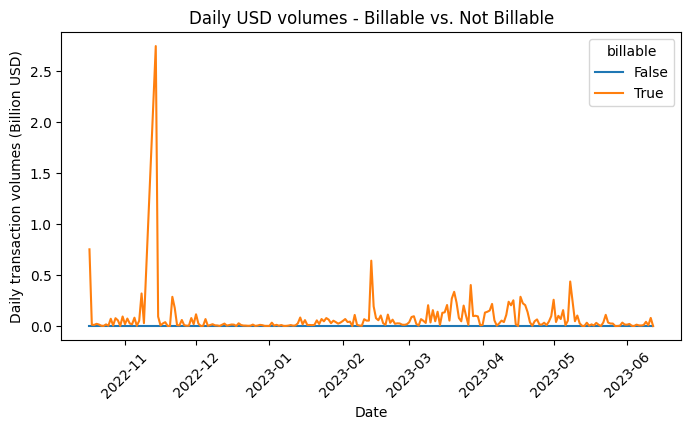

In [12]:
temp_df = vol_df.groupby(["day", "billable"])["fiat_amount"].sum().reset_index()
temp_df["fiat_amount"] = temp_df["fiat_amount"]/1000000000

plt.figure(figsize=(8,4))
sns.lineplot(data=temp_df, x="day", y="fiat_amount", hue="billable")
plt.ylabel("Daily transaction volumes (Billion USD)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("Daily USD volumes - Billable vs. Not Billable")
plt.show()

In [13]:
day_vols_df = (
    vol_df[vol_df["billable"]==True]
    .groupby(["day","billable_type_s"])
    ["fiat_amount"].sum().reset_index()
)
day_vols_df["fiat_amount"] = day_vols_df["fiat_amount"]/1000000000

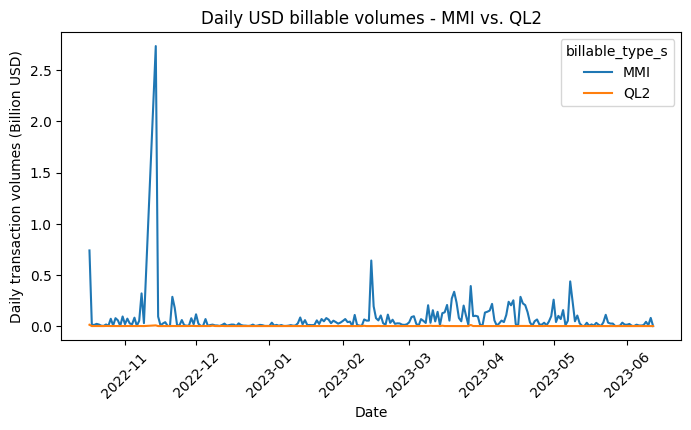

In [14]:
plt.figure(figsize=(8,4))
sns.lineplot(data=day_vols_df, x="day", y="fiat_amount", hue="billable_type_s")
plt.ylabel("Daily transaction volumes (Billion USD)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("Daily USD billable volumes - MMI vs. QL2")
plt.show()

In [15]:
day_vols_df.groupby("billable_type_s")["fiat_amount"].agg(["mean", "std"])

,mean,std
billable_type_s,,
MMI,0.072101,0.198813
QL2,0.000462,0.001260


In [16]:
pd.DataFrame(day_vols_df.groupby("billable_type_s")["fiat_amount"].quantile([0, 0.25,  0.5, 0.75, 1]))

fiat_amount
billable_type_s                   
MMI             0.00  1.124944e-04
                0.25  8.060102e-03
                0.50  2.580139e-02
                0.75  7.210818e-02
                1.00  2.736749e+00
QL2             0.00  3.128496e-08
                0.25  2.389286e-05
                0.50  1.520809e-04
                0.75  4.590041e-04
                1.00  1.271292e-02

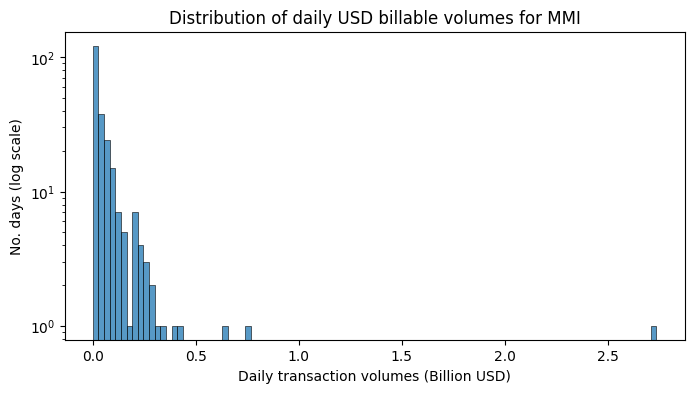

In [17]:
temp_df = day_vols_df[day_vols_df["billable_type_s"]=="MMI"]

plt.figure(figsize=(8,4))
sns.histplot(data=temp_df, x="fiat_amount", bins=100)
plt.yscale('log')
plt.xlabel("Daily transaction volumes (Billion USD)")
plt.ylabel("No. days (log scale)")
plt.title("Distribution of daily USD billable volumes for MMI")
plt.show()

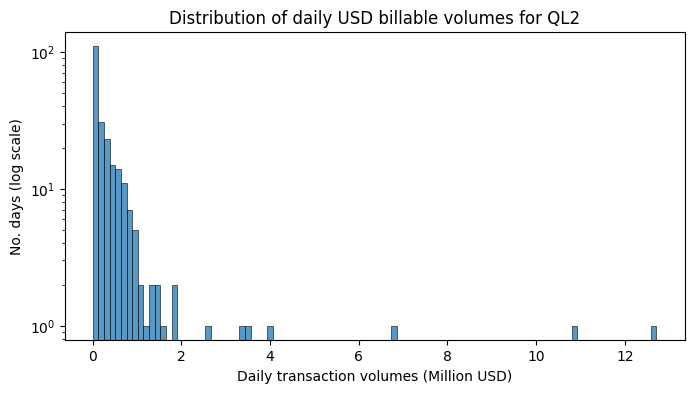

In [18]:
temp_df = day_vols_df[day_vols_df["billable_type_s"]=="QL2"].copy()
temp_df["fiat_amount"] = temp_df["fiat_amount"]*1000

plt.figure(figsize=(8,4))
sns.histplot(data=temp_df, x="fiat_amount", bins=100)
plt.yscale('log')
plt.xlabel("Daily transaction volumes (Million USD)")
plt.ylabel("No. days (log scale)")
plt.title("Distribution of daily USD billable volumes for QL2")
plt.show()

## Service fees

In [19]:
day_fees_df = (
    vol_df[vol_df["billable"]==True]
    .groupby(["day", "billable_type_s"])
    ["fee_amount"].sum().reset_index()
)

day_fees_df["fee_amount"] = day_fees_df["fee_amount"]/1000

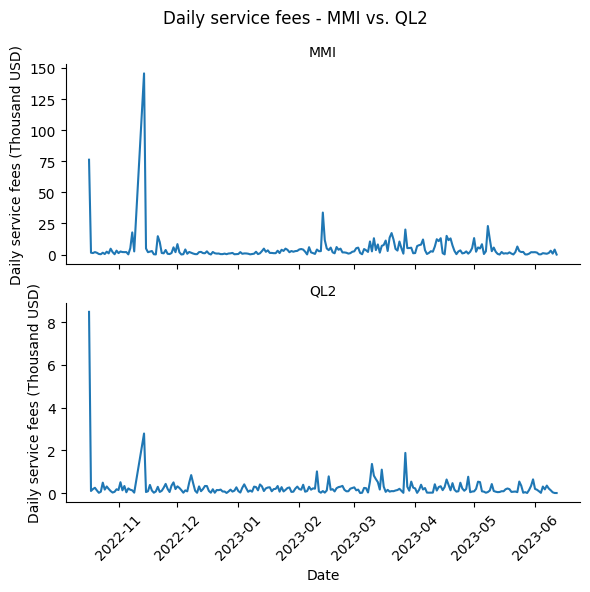

In [20]:
g = sns.relplot(data=day_fees_df, x="day", y="fee_amount", row="billable_type_s", 
                kind="line", height=3, aspect=2, facet_kws={"sharey":False})
g.set_axis_labels("Date", "Daily service fees (Thousand USD)")
g.set_titles("{row_name}") 
plt.xticks(rotation=45)
plt.suptitle("Daily service fees - MMI vs. QL2")
plt.tight_layout()
plt.show()

In [21]:
day_fees_df.groupby("billable_type_s")["fee_amount"].agg(["mean", "std"])

,mean,std
billable_type_s,,
MMI,4.451418,11.274692
QL2,0.256637,0.608090


In [22]:
pd.DataFrame(day_fees_df.groupby("billable_type_s")["fee_amount"].quantile([0, 0.25,  0.5, 0.75, 1]))

fee_amount
billable_type_s                 
MMI             0.00    0.053345
                0.25    0.963274
                0.50    2.066132
                0.75    4.491492
                1.00  145.578684
QL2             0.00    0.001000
                0.25    0.072249
                0.50    0.153724
                0.75    0.280451
                1.00    8.476357

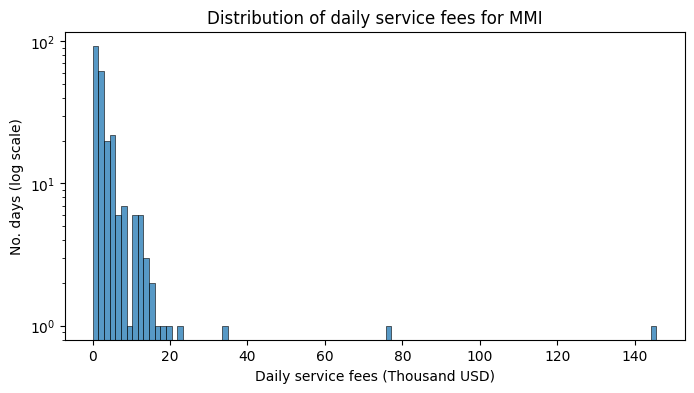

In [23]:
temp_df = day_fees_df[day_fees_df["billable_type_s"]=="MMI"].copy()

plt.figure(figsize=(8,4))
sns.histplot(data=temp_df, x="fee_amount", bins=100)
plt.yscale('log')
plt.xlabel("Daily service fees (Thousand USD)")
plt.ylabel("No. days (log scale)")
plt.title("Distribution of daily service fees for MMI")
plt.show()

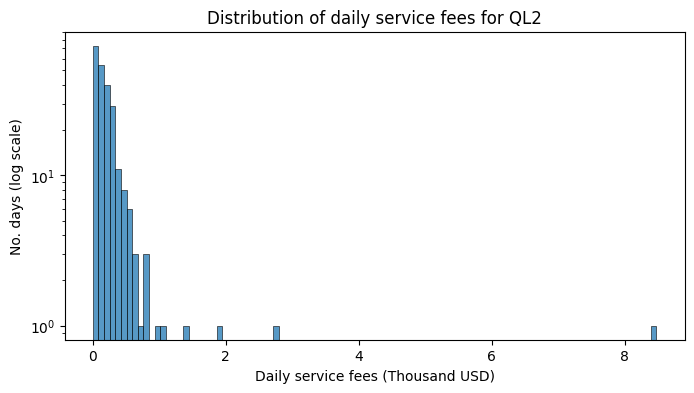

In [24]:
temp_df = day_fees_df[day_fees_df["billable_type_s"]=="QL2"].copy()

plt.figure(figsize=(8,4))
sns.histplot(data=temp_df, x="fee_amount", bins=100)
plt.yscale('log')
plt.xlabel("Daily service fees (Thousand USD)")
plt.ylabel("No. days (log scale)")
plt.title("Distribution of daily service fees for QL2")
plt.show()